## Data Challenge3:  Conversion Rate

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

1. Predict conversion rate

2. Come up with recommendations for the product team and the marketing team to improve conversion rate

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("../conversion_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


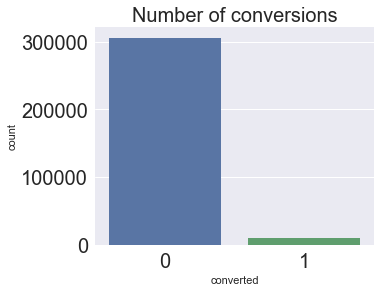

In [5]:
plt.figure(figsize=(5,4))
sns.countplot(x='converted', data=data)
plt.title("Number of conversions", size=20)
plt.tick_params(labelsize=20)

In [26]:
data.converted.value_counts(normalize=True).mul(100)

0    96.774806
1     3.225194
Name: converted, dtype: float64

### Data is highly imbalanced : Converted = 3.2 % and Not converted = 96.7 %

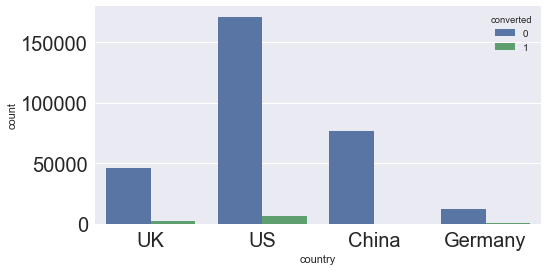

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(x="country", hue="converted", data=data)
plt.tick_params(labelsize=20)

In [33]:
data.groupby(['country'])['converted'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()

,country,converted,percentage
0,China,0,99.866844
1,China,1,0.133156
2,Germany,0,93.757181
3,Germany,1,6.242819
4,UK,0,94.738797
5,UK,1,5.261203
6,US,0,96.219931
7,US,1,3.780069


### Germany seems to be on the top for conversion rate and China on the bottom

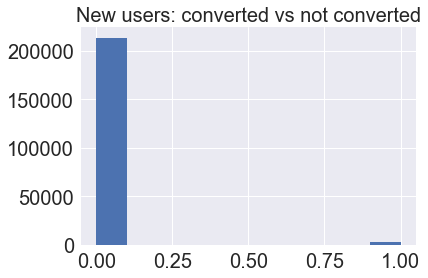

In [7]:
data.converted[data.new_user==1].hist()
plt.tick_params(labelsize=20)
plt.title("New users: converted vs not converted", size=20)

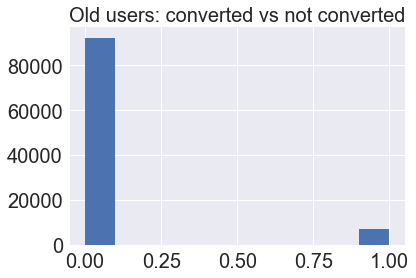

In [8]:
data.converted[data.new_user==0].hist()
plt.tick_params(labelsize=20)
plt.title("Old users: converted vs not converted", size=20)

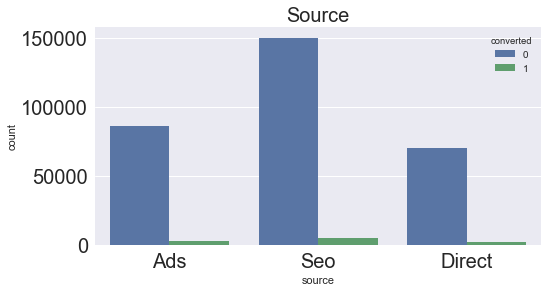

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(x="source", hue="converted", data=data)
plt.title("Source", size=20)
plt.tick_params(labelsize=20)

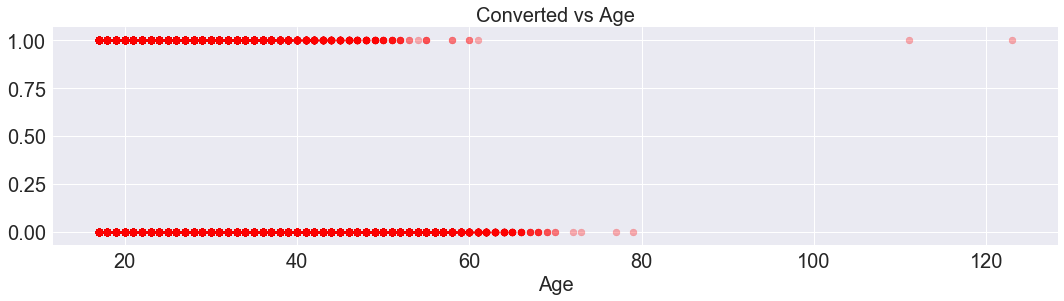

In [10]:
plt.figure(figsize=(18,4))
plt.scatter(data.age, data.converted, alpha=0.3, color='r')
plt.title("Converted vs Age", size=20)
plt.xlabel("Age", size=20)
plt.tick_params(labelsize=20)

Looks like there are some outliers in the age data..lets remove them

In [11]:
data = data[data.age < 80 ]

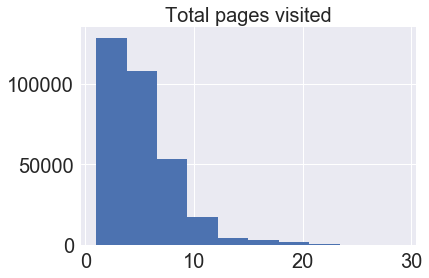

In [12]:
data.total_pages_visited.hist()
plt.title("Total pages visited", size=20)
plt.tick_params(labelsize=20)

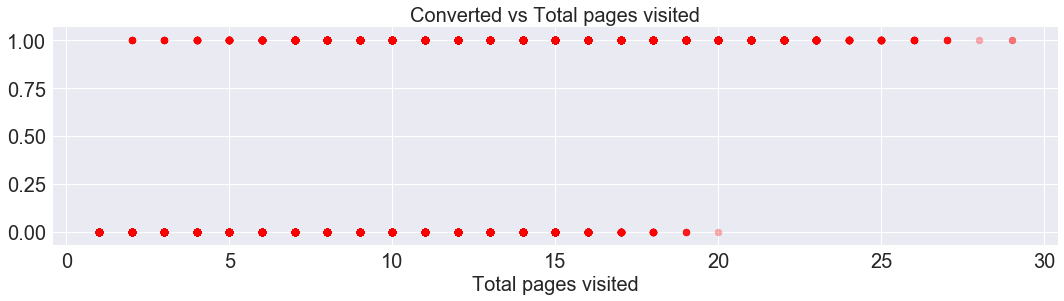

In [13]:
plt.figure(figsize=(18,4))
plt.scatter(data.total_pages_visited, data.converted, alpha=0.3, color='r')
plt.title("Converted vs Total pages visited", size=20)
plt.xlabel("Total pages visited", size=20)
plt.tick_params(labelsize=20)

In [14]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


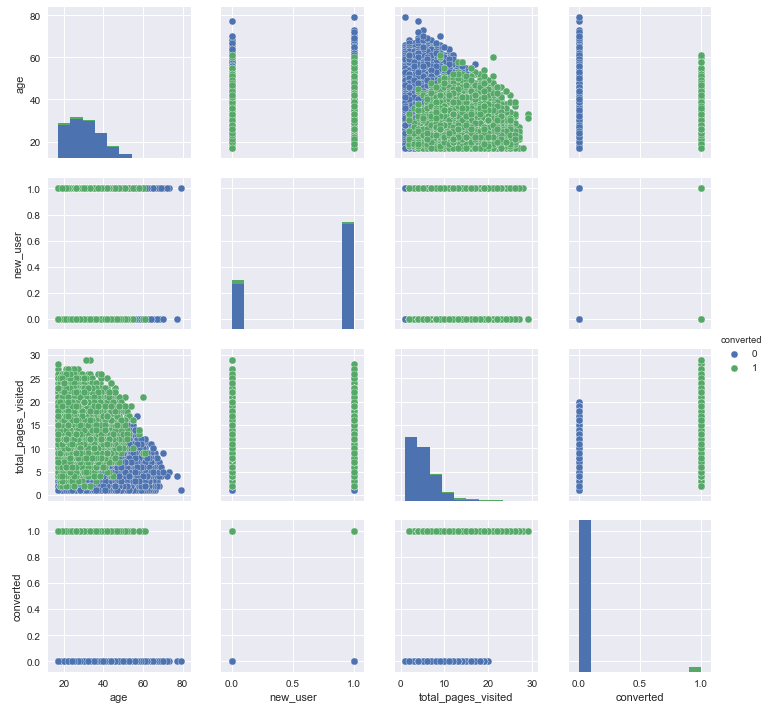

In [16]:
sns.pairplot(data=data, hue='converted')

In [39]:
# Lets build a model to predict if a user converts or not

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

df = pd.get_dummies(data=data, columns=['country', 'source'])

features_to_use = ['age', 'new_user', 'total_pages_visited', 'country_China', \
                   'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']

X = df[features_to_use].values
y = df["converted"].values

#balance data using SMOTE since the data is highly imbalanced
sm = SMOTE(ratio='auto', kind='regular', random_state=42)
X_res, y_res = sm.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=24)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

#clf = LogisticRegression()
clf = DecisionTreeClassifier()
#clf = RandomForestClassifier(n_estimators=100)

cv_ssplit = ShuffleSplit(n_splits=5, test_size=0.3, random_state=100)
cv_score = cross_val_score(clf, X_train, y_train, cv=cv_ssplit, scoring = 'f1')
    
print("Average cross-validation F1 score: %0.4f +/- %0.4f\n" % (cv_score.mean(), cv_score.std()*2))
        
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Test set F1 score : " + str(f1_score(y_test, pred)))
print("Test set accuracy : " + str(accuracy_score(y_test, pred)))
print("\n Classification Report: \n" + classification_report(y_test, pred))


Average cross-validation F1 score: 0.9788 +/- 0.0007

Test set F1 score : 0.979820090608
Test set accuracy : 0.979814814815

 Classification Report: 
             precision    recall  f1-score   support

          0       0.98      0.98      0.98     92027
          1       0.98      0.98      0.98     91573

avg / total       0.98      0.98      0.98    183600



(array([ 306000.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  306000.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

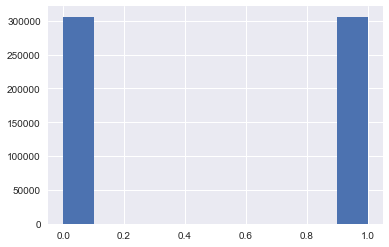

In [58]:
# Lets check the balance of the data after SMOTE is applied 
plt.hist(y_res)

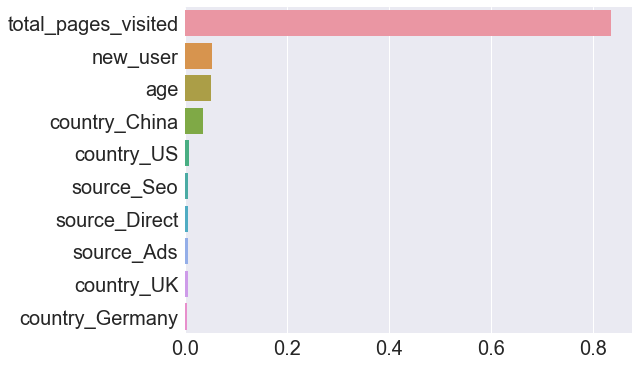

In [40]:
plt.figure(figsize=(8, 6))
feat_imp_df = pd.DataFrame({"feature":features_to_use, "importance":clf.feature_importances_})
feat_imp_df.sort_values("importance", inplace=True, ascending=False)
sns.barplot(x=feat_imp_df.importance.values, y = feat_imp_df.feature.values, orient='h')
plt.tick_params(labelsize=20)

## Conclusions

#### 1. The data is highly unbalanced - converted fraction of 3.2 % vs 96.8 not converted

#### 2. After balancing the data with SMOTE package and using a decision tree classifier  the model can predict conversion rate with an accuracy of 98% and similar precision and recall values. 

#### 3. Number of pages visited seems to be the most important factor in determining conversion rate

#### 4. While Germany has best conversion ratio, China seems to be far behind all the countries in the data. So, need to rethink critically about improving the conversion rate in Chinese market

#### 5. Age seems to matter a little for conversion rate. Above the age of 50 or 55 years there are hardly any one who converted. May be targetting this demographics may help, if it make sense for the product.